In [1]:
!pip3 install transformers sentencepiece

In [2]:
binary = True
translate = False

# Carregando tweets

In [3]:
import pandas as pd

In [4]:
if translate:
  data_df = pd.read_csv("/content/drive/MyDrive/Mestrado/transformers/data/tweetsentbr/tweetsentbr_test.csv", index_col=0)
else:
  data_df = pd.read_csv("/content/drive/MyDrive/Mestrado/transformers/data/tweetsentbr/tweetsentbr_test_en.csv", index_col=0)

In [5]:
if binary:
    data_df = data_df[data_df["label"] != 0]
    data_df["label"] -= 1

In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1836 entries, 2403 to 7786
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   label            1836 non-null   int64 
 1   text             1836 non-null   object
 2   translated_text  1836 non-null   object
dtypes: int64(1), object(2)
memory usage: 57.4+ KB


# Tradução de tweets

In [7]:
from transformers import pipeline, AutoModel, AutoTokenizer
from tqdm.notebook import tqdm

In [8]:
if translate:
  # Pipeline de tradução
  translation_pipeline = pipeline(
      "translation", 
      model="Helsinki-NLP/opus-mt-ROMANCE-en",
      device=0
  )
  print(translation_pipeline.model.config)

In [9]:
if translate:
  translated_tweets = []
  for tweet in tqdm(data_df["text"]):
    try:
      translated_tweets.append(
        translation_pipeline(tweet, tgt_lang="pt_br")[0]["translation_text"]
      )
    except:
      print(tweet)
      break

  # Armazena as traduções no arquivo auxiliar
  data_df["translated_text"] = translated_tweets
  data_df.to_csv("/content/drive/MyDrive/Mestrado/transformers/data/tweetsentbr_test_en.csv")



In [10]:
data_df.head(3)

,label,text,translated_text
2403,0,Começou o The Noite com o Charlie Hunnam,♪ The Night With Charlie Hunnam ♪
1349,1,"No twitter a 3ª feira é chata,pois todo mundo ...","On the twitter on the 3rd is boring, because e..."
5438,1,A Miriam só não roda pq eu acho que o tal sorv...,Miriam just doesn't turn pq I think that Ferna...


# NLI

In [11]:
# Modelo para zero-shot
classifier = pipeline("zero-shot-classification", device=0)

No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)


In [12]:
classifier.model.config

BartConfig {
  "_name_or_path": "facebook/bart-large-mnli",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_final_layer_norm": false,
  "architectures": [
    "BartForSequenceClassification"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "contradiction",
    "1": "neutral",
    "2": "entailment"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "contradiction": 0,
    "entailment": 2,
    "neutral": 1
  },
  "max_position_embeddings": 1024,
  "model_type": "bart",
  

# Combinando pipelines

In [13]:
hypothesis = 'This example trasmits {} sentiment.'

In [14]:
if binary:
  label2id = {
      "positive": 0,
      "negative": 1
  }
else:
    label2id = {
      "positive": 1,
      "neutral": 0,
      "negative": 2
  }

In [15]:
pred_df = data_df.copy()

In [16]:
classes = ["positive", "negative"] if binary else \
          ["positive", "neutral", "negative"]
classes

['positive', 'negative']

In [17]:
predictions = []
# Fazer sequencialmente pois, caso contrário a estouro de memória da GPU :(
for tweet in tqdm(data_df["translated_text"]):
  predictions.append(
      label2id[classifier(tweet, candidate_labels=classes, hypothesis_template=hypothesis)["labels"][0]]
  )

  0%|          | 0/1836 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:901: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


In [18]:
pred_df["prediction"] = predictions

In [19]:
pred_df.head()

,label,text,translated_text,prediction
2403,0,Começou o The Noite com o Charlie Hunnam,♪ The Night With Charlie Hunnam ♪,0
1349,1,"No twitter a 3ª feira é chata,pois todo mundo ...","On the twitter on the 3rd is boring, because e...",1
5438,1,A Miriam só não roda pq eu acho que o tal sorv...,Miriam just doesn't turn pq I think that Ferna...,1
377,0,Esse jogo não funciona com esse tanto de gente...,This game doesn't work with so many Fatima Enc...,1
753,1,Não tem jeito. Vai ser muito difícil mudar um ...,It's going to be very hard to change a minimum...,1


# Analisando predições

In [20]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt


In [21]:
analysis_df = pred_df.copy()

In [22]:
print(classification_report(analysis_df["label"], analysis_df["prediction"]))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1109
           1       0.70      0.75      0.72       727

    accuracy                           0.78      1836
   macro avg       0.77      0.77      0.77      1836
weighted avg       0.78      0.78      0.78      1836



In [23]:
matrix = confusion_matrix(analysis_df["label"], analysis_df["prediction"])

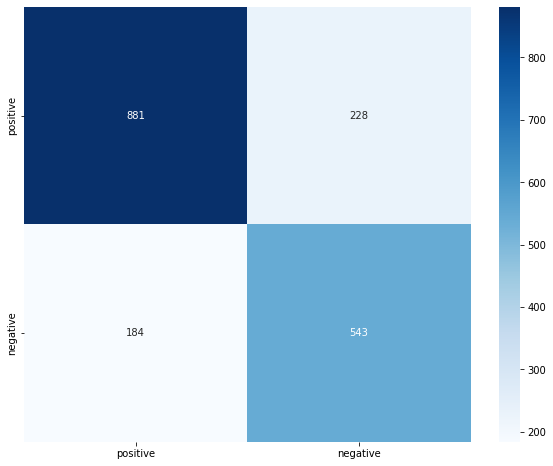

In [24]:
plt.figure(figsize = (10,8))
sns.heatmap(matrix, annot=True, cmap="Blues", xticklabels=classes,yticklabels=classes, fmt='g')

In [25]:
file_name = "zero_shot_binary_preds.csv" if binary else \
            "zero_shot_all_classes_preds.csv" 
file_name

'zero_shot_binary_preds.csv'

In [26]:
analysis_df.to_csv(f"/content/drive/MyDrive/Mestrado/transformers/data/predicoes/{file_name}")